In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from google.colab import drive
import matplotlib.pyplot as plt
import time



In [ ]:

drive.mount('/content/drive')
%cd /content/drive/My Drive/eye/Eye dataset
!ls
image_folder_path = '/content/drive/My Drive/eye/Eye dataset'

def load_images_from_folder(folder_path):
    images = []
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                img = load_image(img_path)
                images.append(img)
    return np.array(images)

def load_image(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((128, 128))
    img = np.array(img)
    img = img.astype('float32') / 255.0
    return img


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/eye/Eye dataset
close_look  forward_look  left_look  right_look


In [ ]:

# Load images from subfolders
train_images = load_images_from_folder(image_folder_path)
train_images = train_images.reshape(train_images.shape[0], 128, 128, 3)  # Add this line to reshape the images

batch_size = 32  # or any batch size you desire
ds = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)

def make_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same", input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))

    return model

discriminator = make_discriminator()


In [ ]:

def make_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(16 * 16 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 128, 128, 3)

    return model

generator = make_generator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake):
    loss = cross_entropy(tf.ones_like(fake), fake)
    return loss

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        discrim_loss = discriminator_loss(real_output, fake_output)

    gradient_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discrim = disc_tape.gradient(discrim_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_of_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discrim, discriminator.trainable_variables))

begin = time.time()


In [ ]:

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        if (epoch + 1) % 10 == 0:
            generate_and_display_images(generator, epoch, seed)

        # if (epoch + 1) % 15 == 0:
        #     checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Time for epoch {epoch+1} is {time.time() - start} sec. Total time is {time.time()-begin}")

    generate_and_display_images(generator, epochs, seed)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 156.8985755443573 sec. Total time is 156.92583656311035
Time for epoch 2 is 140.74834537506104 sec. Total time is 297.6743235588074
Time for epoch 3 is 141.08697319030762 sec. Total time is 438.7622175216675
Time for epoch 4 is 140.66740131378174 sec. Total time is 579.4306139945984
Time for epoch 5 is 141.0260772705078 sec. Total time is 720.4568552970886
Time for epoch 6 is 140.8416702747345 sec. Total time is 861.2994179725647
Time for epoch 7 is 140.79398798942566 sec. Total time is 1002.0943288803101
Time for epoch 8 is 140.79146790504456 sec. Total time is 1142.8859486579895
Time for epoch 9 is 140.74823760986328 sec. Total time is 1283.6343367099762


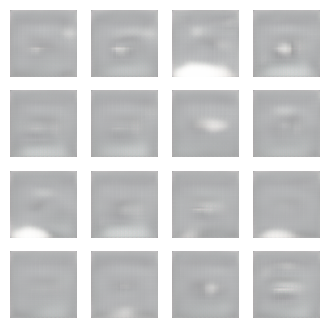

Time for epoch 10 is 142.10761904716492 sec. Total time is 1425.742095708847
Time for epoch 11 is 140.83412384986877 sec. Total time is 1566.576286315918
Time for epoch 12 is 140.55159735679626 sec. Total time is 1707.1280226707458
Time for epoch 13 is 140.607168674469 sec. Total time is 1847.7353475093842
Time for epoch 14 is 140.83902215957642 sec. Total time is 1988.575341463089
Time for epoch 15 is 140.3095099925995 sec. Total time is 2128.8849878311157
Time for epoch 16 is 140.80728220939636 sec. Total time is 2269.6932027339935
Time for epoch 17 is 140.79072761535645 sec. Total time is 2410.4848399162292
Time for epoch 18 is 140.67317008972168 sec. Total time is 2551.158874988556
Time for epoch 19 is 140.6315975189209 sec. Total time is 2691.790605068207


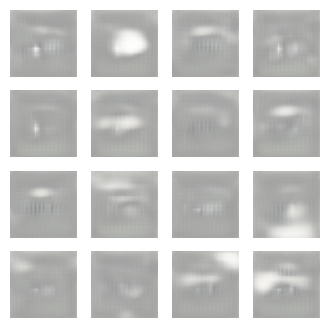

Time for epoch 20 is 141.3685929775238 sec. Total time is 2833.159332752228
Time for epoch 21 is 140.55806970596313 sec. Total time is 2973.7174735069275
Time for epoch 22 is 140.823668718338 sec. Total time is 3114.5412969589233
Time for epoch 23 is 141.00535583496094 sec. Total time is 3255.5467958450317
Time for epoch 24 is 140.82617330551147 sec. Total time is 3396.373138189316
Time for epoch 25 is 140.7587389945984 sec. Total time is 3537.1320173740387
Time for epoch 26 is 140.74432921409607 sec. Total time is 3677.8764922618866
Time for epoch 27 is 140.46868133544922 sec. Total time is 3818.3461050987244
Time for epoch 28 is 140.6486620903015 sec. Total time is 3958.9949214458466
Time for epoch 29 is 140.63540530204773 sec. Total time is 4099.630483150482


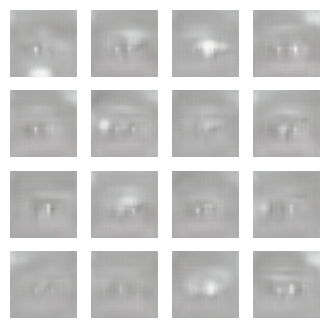

Time for epoch 30 is 141.38110518455505 sec. Total time is 4241.01177239418
Time for epoch 31 is 140.48211789131165 sec. Total time is 4381.495382785797
Time for epoch 32 is 140.8053629398346 sec. Total time is 4522.300901174545
Time for epoch 33 is 140.78144478797913 sec. Total time is 4663.0824999809265
Time for epoch 34 is 140.74915981292725 sec. Total time is 4803.831813335419
Time for epoch 35 is 140.6415774822235 sec. Total time is 4944.473541975021
Time for epoch 36 is 140.972882270813 sec. Total time is 5085.446578025818


In [ ]:

def generate_and_display_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.0)
        plt.axis('off')

    plt.show()
    plt.close()

# Set up training parameters
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32
epochs = 1000
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Initialize optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Start training
train(ds, epochs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')